# Bearing failure Anomaly Detection
---

* 문제상황 및 데이터 살펴보기
* 문제해결 프로세스 정의
    * Data 전처리 및 EDA
    * 시계열 데이터 특성 추출(옵션)
    * 이상 탐지 모델링

In [1]:
# Warnings 제거
import warnings
warnings.filterwarnings('ignore')

## **문제상황 및 데이터 살펴보기**
- 문제상황
---
- B사는 냉장고를 생산하는 업체이다. 냉장고 제작 공정은 컨베이어 벨트 방식으로 제작이 되며, 하나의 공정이 중단될 시 모든 공정이 All stop되는 매우 심각한 특성을 가진다. 
- 냉장고를 제작하는데 있어 주요 공정인 조립설비는 Bearing을 핵심 부품으로 사용한다. Bearing은 사용할 수록 마모가 되어 주기적으로 변경을 해줘야하는 부품 특성을 가지고 있다. 
- B사는 Bearing이 파손되기 이전에 이상점을 감지하여 사전 유지보수(구리스, 윤활제)를 통해 All stop을 사전에 방지하고자 한다.
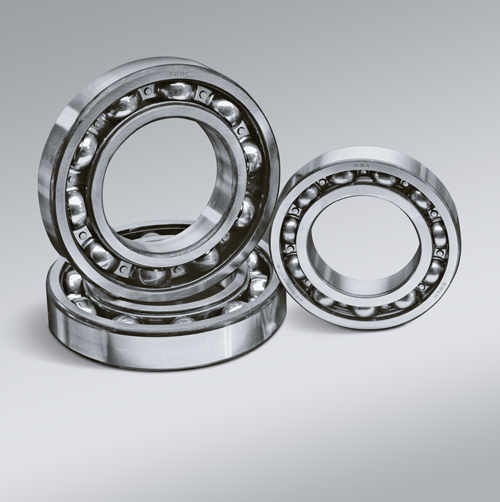

데이터 살펴보기
- Bearing Sensor data
- 데이터 명세

|Column|Description|
|:---|:---|
|index|측정 시간 Index|
|Bearing 1|베어링 1 진동 센서 값|
|Bearing 2|베어링 2 진동 센서 값|
|Bearing 3|베어링 3 진동 센서 값|
|Bearing 4|베어링 4 진동 센서 값|




In [14]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
"""
# 폴더에 저장된 대량의 데이터를 읽어서 하나의 파일로 저장하기, 데이터 준비하기
data_dir = "./bearing_data"  # /와 \를 잘 구분해서 사용바람.
merged_data = pd.DataFrame()

for filename in os.listdir(data_dir):
    dataset = pd.read_csv(os.path.join(data_dir, filename), sep='\t')  # 파일 하나를 읽어온다.
    dataset_mean_abs = np.array(dataset.abs().mean())                  # 파일에서 컬럼별로 절대값을 구하고 평균을 구한다.
    dataset_mean_abs = pd.DataFrame(dataset_mean_abs.reshape(1,4))     # reshape을 통해 1 by 4 형태로 구성하고 데이터프레임화 한다.
    dataset_mean_abs.index = [filename]                                # 파일이름을 인덱스로 설정한다. 
    merged_data = pd.concat([merged_data, dataset_mean_abs])
    
merged_data.columns = ['Bearing 1', 'Bearing 2', 'Bearing 3', 'Bearing 4']
merged_data.head()
"""

In [2]:
"""
# index를 시간형태로 변환
merged_data.index = pd.to_datetime(merged_data.index, format='%Y.%m.%d.%H.%M.%S')
merged_data = merged_data.sort_index()  # index를 기준으로 정렬
merged_data.to_csv('Averaged_BearingTest_Dataset.csv')
print("Dataset shape:", merged_data.shape)
merged_data.head()
"""

Dataset shape: (982, 4)


,Bearing 1,Bearing 2,Bearing 3,Bearing 4
2004-02-12 10:52:39,0.060236,0.074227,0.083926,0.044443
2004-02-12 11:02:39,0.061455,0.073844,0.084457,0.045081
2004-02-12 11:12:39,0.061361,0.075609,0.082837,0.045118
2004-02-12 11:22:39,0.061665,0.073279,0.084879,0.044172
2004-02-12 11:32:39,0.061944,0.074593,0.082626,0.044659


In [44]:
# pd.set option
#pd.set_option('display.max_columns',100)
#pd.set_option('display.max_rows',100)  

# Data read
df = pd.read_csv("Averaged_BearingTest_Dataset.csv")
df.head()

,Unnamed: 0,Bearing 1,Bearing 2,Bearing 3,Bearing 4
0,2004-02-12 10:52:39,0.060236,0.074227,0.083926,0.044443
1,2004-02-12 11:02:39,0.061455,0.073844,0.084457,0.045081
2,2004-02-12 11:12:39,0.061361,0.075609,0.082837,0.045118
3,2004-02-12 11:22:39,0.061665,0.073279,0.084879,0.044172
4,2004-02-12 11:32:39,0.061944,0.074593,0.082626,0.044659


In [45]:
df.columns = ['time', 'Bearing1','Bearing2','Bearing3','Bearing4']
df.head()

,time,Bearing1,Bearing2,Bearing3,Bearing4
0,2004-02-12 10:52:39,0.060236,0.074227,0.083926,0.044443
1,2004-02-12 11:02:39,0.061455,0.073844,0.084457,0.045081
2,2004-02-12 11:12:39,0.061361,0.075609,0.082837,0.045118
3,2004-02-12 11:22:39,0.061665,0.073279,0.084879,0.044172
4,2004-02-12 11:32:39,0.061944,0.074593,0.082626,0.044659



## 문제해결 프로세스 정의
---
1) 문제정의
- 냉장고 공정 주요 조립설비의 고장이 발생하면 Line All stop 리스크(고장나서 라인스탑되면 베어링 교체하고 다시 돌리면 안되나? 라인스탑되면 생산이 늦어지고 납기가 늘어나고, 지연에 대한 소비자 불만 등으로 이어진다.)
- 조립설비의 핵심 부품인 Bearing 마모에 따른 설비 고장

2) 기대효과 (우리가 문제를 해결하면 뭐가 좋을까?)
- 설비고장 사전에 방지하여, Line stop 방지(설비가 쉬는 시간에 점검하자)
- Line stop으로 인한 점검 시간 및 비용 절감
- 계획 대비 생산량 달성

3) 해결방안 (사실 활용가능한 방법을 생각해봐야 한다, 현업의 로직활용, 경험에 의한 방법, 모델링에 의한 방법 등을 정하고 우선순위를 만든 후 달성 가능한 방법을 생각해봐야 한다).
- 베어링 센서 데이터 이상탐지를 통해 사전 고장발생 방지
    - Data 전처리 및 EDA 
    - 시계열 센서 데이터 분석 
    - 이상탐지 모델링 

4) 성과측정
- 모델 활용 전/후 Line stop 횟수 비교
- 모델 활용 전/후 계획 대비 생산률 비교

5) 현업적용
- Bearing Sensor Data 실시간 수집 체계 구축
- Model에 Input할 window time 결정 (예: 샘플링 주기가 1초인데, 이를 15분 정도 데이터가 모이면 평균화 해보자)
- Sensor Data Model Input 및 Alarm, 대시보드 만들기
- Anomaly Points 발견 시 유휴시간 장비 점검

## Data 전처리 및 EDA

### Data 전처리  
- 수집된 데이터의 기본 정보들을 확인  

  (1) Data shape(형태) 확인  
  (2) Data type 확인  
  (3) Null값 확인 (※ 빈 값의 Data)  
  (4) Outlier 확인 (※ 정상적인 범주를 벗어난 Data)    

In [5]:
# Data 형태 확인
# 982 row, 5 col로 구성됨
df.shape

(982, 5)

In [6]:
# Data type 확인
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 982 entries, 0 to 981
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   time      982 non-null    object 
 1   Bearing1  982 non-null    float64
 2   Bearing2  982 non-null    float64
 3   Bearing3  982 non-null    float64
 4   Bearing4  982 non-null    float64
dtypes: float64(4), object(1)
memory usage: 38.5+ KB


In [7]:
# Null 값 확인
df.isna().sum()

time        0
Bearing1    0
Bearing2    0
Bearing3    0
Bearing4    0
dtype: int64

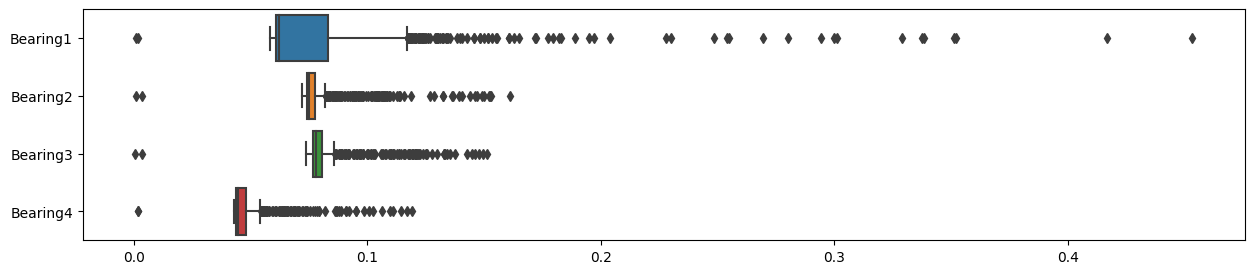

In [20]:
# Outlier 확인
plt.figure(figsize=(15, 3))
sns.boxplot(df, orient="h")
plt.show()

### Data EDA
---
* 데이터 특성 파악을 위한 초기 탐색

In [9]:
df.head()

,time,Bearing1,Bearing2,Bearing3,Bearing4
0,2004-02-12 10:52:39,0.060236,0.074227,0.083926,0.044443
1,2004-02-12 11:02:39,0.061455,0.073844,0.084457,0.045081
2,2004-02-12 11:12:39,0.061361,0.075609,0.082837,0.045118
3,2004-02-12 11:22:39,0.061665,0.073279,0.084879,0.044172
4,2004-02-12 11:32:39,0.061944,0.074593,0.082626,0.044659


In [46]:
# 시간형태 데이터 타입 변경 및 Index 설정
df['time'] = pd.to_datetime(df['time'])
df.set_index('time', inplace=True)
df

,Bearing1,Bearing2,Bearing3,Bearing4
time,,,,
2004-02-12 10:52:39,0.060236,0.074227,0.083926,0.044443
2004-02-12 11:02:39,0.061455,0.073844,0.084457,0.045081
2004-02-12 11:12:39,0.061361,0.075609,0.082837,0.045118
2004-02-12 11:22:39,0.061665,0.073279,0.084879,0.044172
2004-02-12 11:32:39,0.061944,0.074593,0.082626,0.044659
...,...,...,...,...
2004-02-19 05:42:39,0.453335,0.161016,0.137440,0.119047
2004-02-19 05:52:39,0.337583,0.132400,0.144992,0.092125
2004-02-19 06:02:39,0.351111,0.152266,0.151299,0.100817


In [11]:
# 전체 Data 기간 확인
df.index[-1] - df.index[0]

Timedelta('6 days 19:30:00')

<Axes: xlabel='time'>

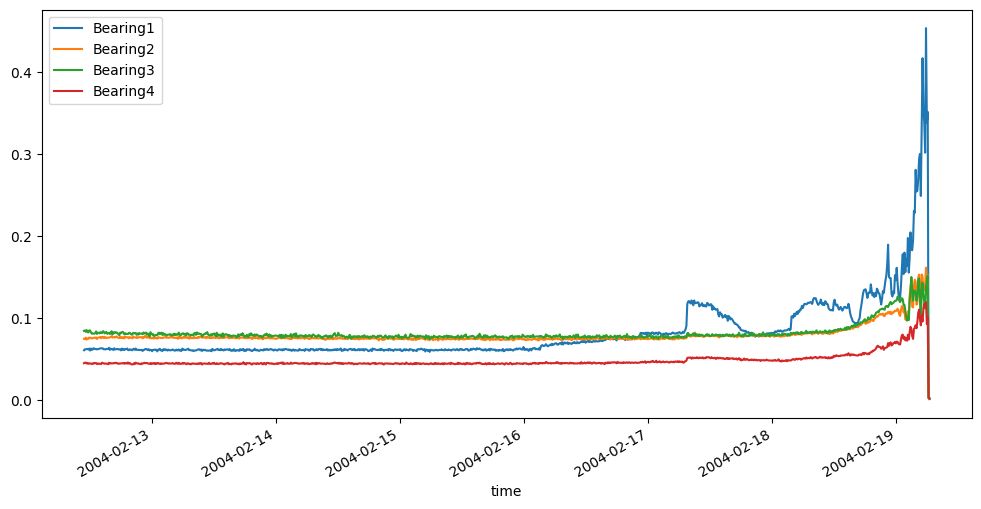

In [12]:
# Plotting 전체 데이터 
df.plot(figsize = (12, 6))
# 뒷부분에서 고장이 발생된 듯 함.
# 2004년 2월 17일을 기준으로 나눠보자.

<Axes: xlabel='time'>

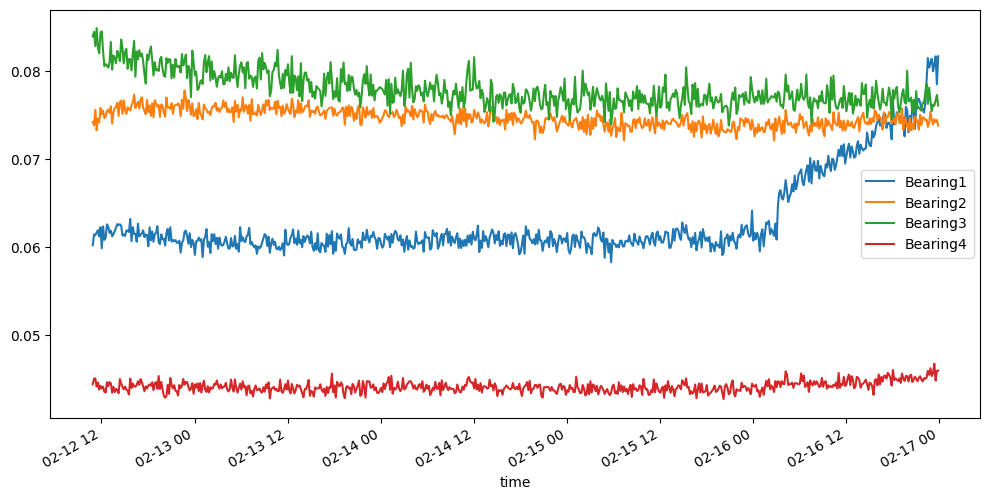

In [13]:
# Before Data 기간 확인
BeforeData = df.loc[:'2004-02-16']
BeforeData.plot(figsize = (12, 6))
# 1번 베어링은 2월 16일쯤에서 부터 커진다.

<Axes: xlabel='time'>

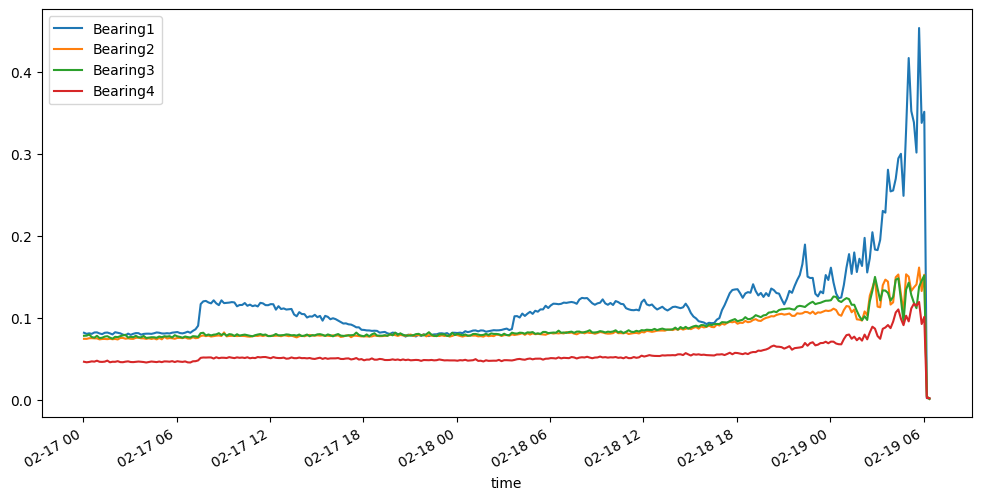

In [19]:
# ▶ After Data 기간 확인
AfterData = df.loc['2004-02-17':]
AfterData.plot(figsize = (12, 6))
# 베어링 2,3,4는 2월 19일부터 문제가 있어 보임.
# 베어링 1, 2, 3, 4에 대해 어느 정도 이상탐지를 위한 방법이 보이는 것 같음. 
# 베어링간 상관관계는 없다고 했으니, 단변량 이상탐지 방법도 가능

## 시계열 데이터 특성 추출(옵션)

In [115]:
df

,Bearing1,Bearing2,Bearing3,Bearing4
time,,,,
2004-02-12 10:52:39,0.060236,0.074227,0.083926,0.044443
2004-02-12 11:02:39,0.061455,0.073844,0.084457,0.045081
2004-02-12 11:12:39,0.061361,0.075609,0.082837,0.045118
2004-02-12 11:22:39,0.061665,0.073279,0.084879,0.044172
2004-02-12 11:32:39,0.061944,0.074593,0.082626,0.044659
...,...,...,...,...
2004-02-19 05:42:39,0.453335,0.161016,0.137440,0.119047
2004-02-19 05:52:39,0.337583,0.132400,0.144992,0.092125
2004-02-19 06:02:39,0.351111,0.152266,0.151299,0.100817


### Date 관련 변수 추출

In [23]:
df.index

DatetimeIndex(['2004-02-12 10:52:39', '2004-02-12 11:02:39',
               '2004-02-12 11:12:39', '2004-02-12 11:22:39',
               '2004-02-12 11:32:39', '2004-02-12 11:42:39',
               '2004-02-12 11:52:39', '2004-02-12 12:02:39',
               '2004-02-12 12:12:39', '2004-02-12 12:22:39',
               ...
               '2004-02-19 04:52:39', '2004-02-19 05:02:39',
               '2004-02-19 05:12:39', '2004-02-19 05:22:39',
               '2004-02-19 05:32:39', '2004-02-19 05:42:39',
               '2004-02-19 05:52:39', '2004-02-19 06:02:39',
               '2004-02-19 06:12:39', '2004-02-19 06:22:39'],
              dtype='datetime64[ns]', name='time', length=982, freq=None)

In [22]:
# 년, 월, 요일, 시간
# [참조] x.year, x.month, x.day, x.hour, x.minute, x.second, x.microsecond, x.weekday()
df.index.hour

Index([10, 11, 11, 11, 11, 11, 11, 12, 12, 12,
       ...
        4,  5,  5,  5,  5,  5,  5,  6,  6,  6],
      dtype='int32', name='time', length=982)

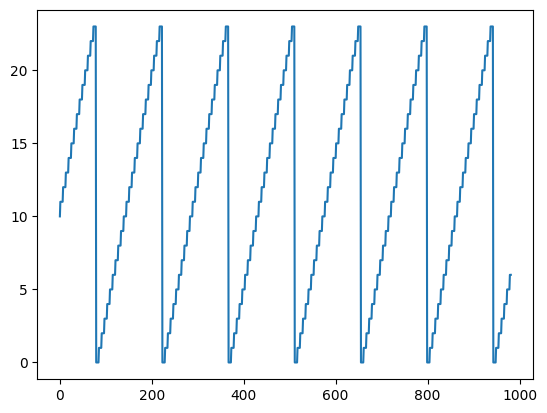

In [24]:
plt.plot(df.index.hour)

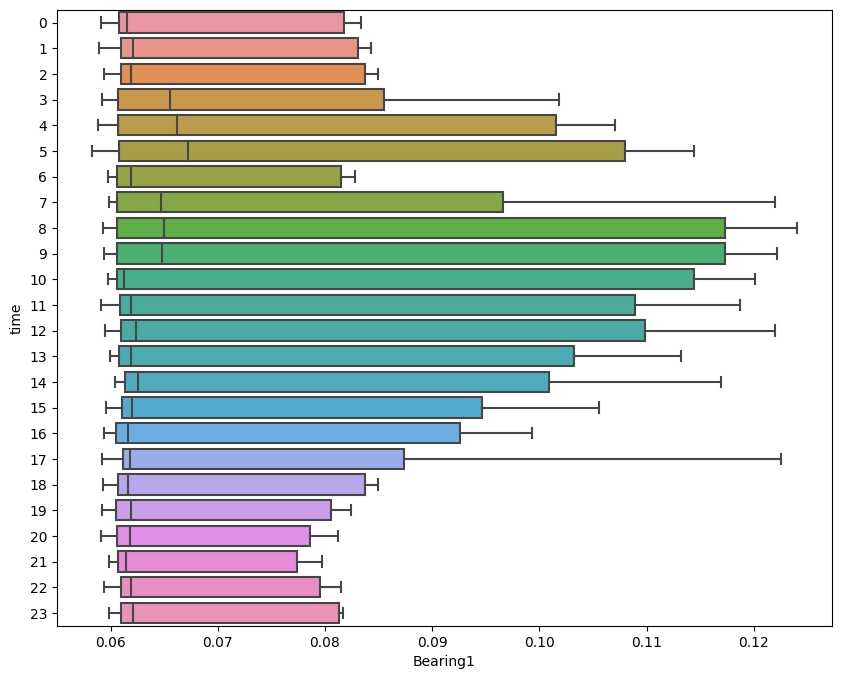

In [47]:
# ▶ Box plot 활용 시간별 Bearing 분포 확인
plt.figure(figsize=(10, 8))
sns.boxplot(x=df['Bearing1'], y=df.index.hour.astype('str'), order=[str(i) for i in range(24)], showfliers = False)
plt.show()

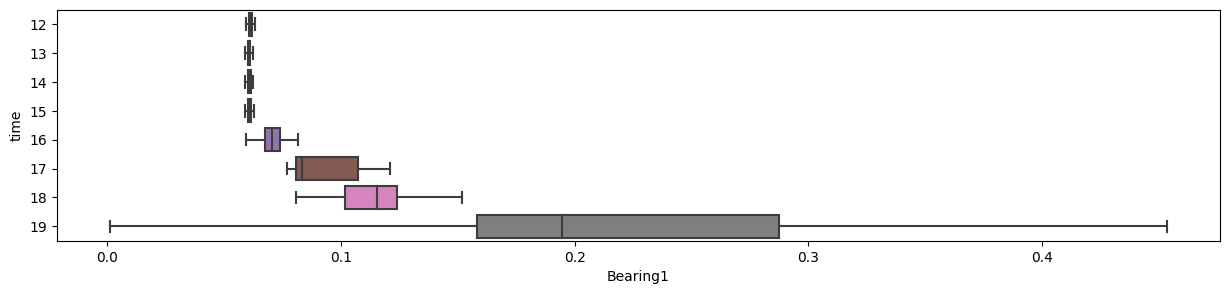

In [48]:
# ▶ Box plot 활용 일별 Bearing 분포 확인
plt.figure(figsize=(15, 3))
sns.boxplot(x=df['Bearing1'], y=df.index.day.astype('str'), showfliers = False)
plt.show()

### lag(지연) 데이터 생성
* 시계열 데이터에서 이전에 값을 고려할 때 lag(지연) 데이터를 사용, shift() 활용

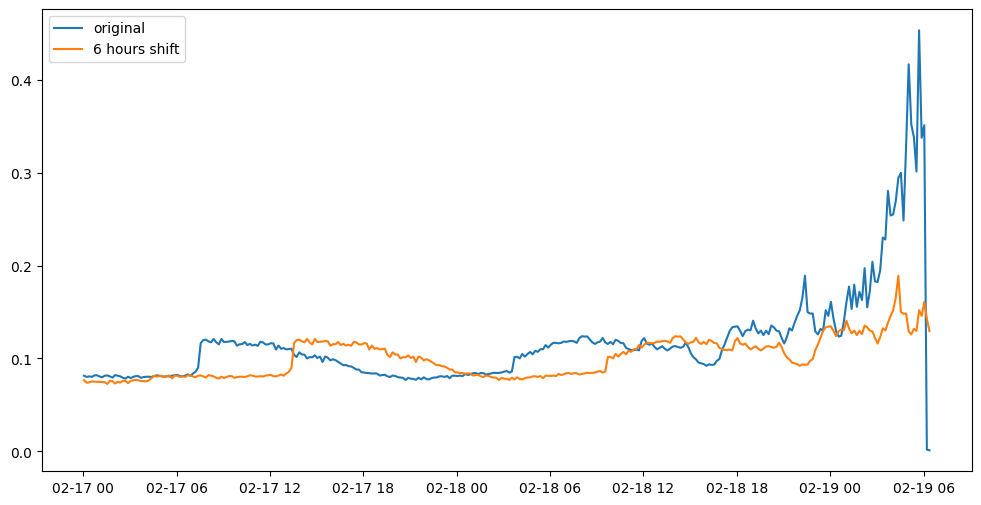

In [53]:
# shift 명령어 사용 ,lag 데이터 생성
# 'fill_value' = 0 옵션을 통해 NaN 값 처리
# ▶ Shift(n)을 통해 지연 기간 조정 가능

plt.figure(figsize=(12, 6))
plt.plot(df.loc['2004-02-17':, 'Bearing1'], label='original')
plt.plot(df.shift(6*60//10, fill_value=0).loc['2004-02-17':, 'Bearing1'], label='6 hours shift')
plt.legend()
plt.show()

In [55]:
df6h = df.shift(6*60//10, fill_value=0)
df6h

,Bearing1,Bearing2,Bearing3,Bearing4
time,,,,
2004-02-12 10:52:39,0.000000,0.000000,0.000000,0.000000
2004-02-12 11:02:39,0.000000,0.000000,0.000000,0.000000
2004-02-12 11:12:39,0.000000,0.000000,0.000000,0.000000
2004-02-12 11:22:39,0.000000,0.000000,0.000000,0.000000
2004-02-12 11:32:39,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...
2004-02-19 05:42:39,0.151880,0.108575,0.120528,0.070505
2004-02-19 05:52:39,0.145859,0.108005,0.120645,0.068641
2004-02-19 06:02:39,0.160895,0.108649,0.121147,0.070631


In [60]:
df_6 = pd.concat([df, df6h.add_suffix('_6h')], axis=1)
df_6

,Bearing1,Bearing2,Bearing3,Bearing4,Bearing1_6h,Bearing2_6h,Bearing3_6h,Bearing4_6h
time,,,,,,,,
2004-02-12 10:52:39,0.060236,0.074227,0.083926,0.044443,0.000000,0.000000,0.000000,0.000000
2004-02-12 11:02:39,0.061455,0.073844,0.084457,0.045081,0.000000,0.000000,0.000000,0.000000
2004-02-12 11:12:39,0.061361,0.075609,0.082837,0.045118,0.000000,0.000000,0.000000,0.000000
2004-02-12 11:22:39,0.061665,0.073279,0.084879,0.044172,0.000000,0.000000,0.000000,0.000000
2004-02-12 11:32:39,0.061944,0.074593,0.082626,0.044659,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...
2004-02-19 05:42:39,0.453335,0.161016,0.137440,0.119047,0.151880,0.108575,0.120528,0.070505
2004-02-19 05:52:39,0.337583,0.132400,0.144992,0.092125,0.145859,0.108005,0.120645,0.068641
2004-02-19 06:02:39,0.351111,0.152266,0.151299,0.100817,0.160895,0.108649,0.121147,0.070631


### 이동 평균(Rolling window)
---
* smoothing 효과

In [68]:
# NaN 값 처리 
df_6 = df_6.iloc[6*60//10:]
df_6

,Bearing1,Bearing2,Bearing3,Bearing4,Bearing1_6h,Bearing2_6h,Bearing3_6h,Bearing4_6h
time,,,,,,,,
2004-02-12 16:52:39,0.061219,0.075748,0.082365,0.044376,0.060236,0.074227,0.083926,0.044443
2004-02-12 17:02:39,0.061413,0.076759,0.081682,0.045033,0.061455,0.073844,0.084457,0.045081
2004-02-12 17:12:39,0.061580,0.077017,0.081992,0.044675,0.061361,0.075609,0.082837,0.045118
2004-02-12 17:22:39,0.061917,0.075828,0.081084,0.044192,0.061665,0.073279,0.084879,0.044172
2004-02-12 17:32:39,0.061149,0.075487,0.079664,0.043657,0.061944,0.074593,0.082626,0.044659
...,...,...,...,...,...,...,...,...
2004-02-19 05:42:39,0.453335,0.161016,0.137440,0.119047,0.151880,0.108575,0.120528,0.070505
2004-02-19 05:52:39,0.337583,0.132400,0.144992,0.092125,0.145859,0.108005,0.120645,0.068641
2004-02-19 06:02:39,0.351111,0.152266,0.151299,0.100817,0.160895,0.108649,0.121147,0.070631


In [69]:
# rolling 명령어 사용 이동 평균 생성
df_6_window = df_6.rolling('6h').mean()
df_6_window

,Bearing1,Bearing2,Bearing3,Bearing4,Bearing1_6h,Bearing2_6h,Bearing3_6h,Bearing4_6h
time,,,,,,,,
2004-02-12 16:52:39,0.061219,0.075748,0.082365,0.044376,0.060236,0.074227,0.083926,0.044443
2004-02-12 17:02:39,0.061316,0.076254,0.082023,0.044704,0.060846,0.074035,0.084192,0.044762
2004-02-12 17:12:39,0.061404,0.076508,0.082013,0.044695,0.061018,0.074560,0.083740,0.044881
2004-02-12 17:22:39,0.061532,0.076338,0.081781,0.044569,0.061179,0.074240,0.084025,0.044704
2004-02-12 17:32:39,0.061456,0.076168,0.081357,0.044387,0.061332,0.074310,0.083745,0.044695
...,...,...,...,...,...,...,...,...
2004-02-19 05:42:39,0.221328,0.122458,0.122771,0.085785,0.135619,0.101399,0.108115,0.062651
2004-02-19 05:52:39,0.226653,0.123135,0.123447,0.086437,0.135940,0.101757,0.108740,0.062976
2004-02-19 06:02:39,0.231937,0.124347,0.124285,0.087276,0.136671,0.102206,0.109453,0.063363


<Axes: xlabel='time'>

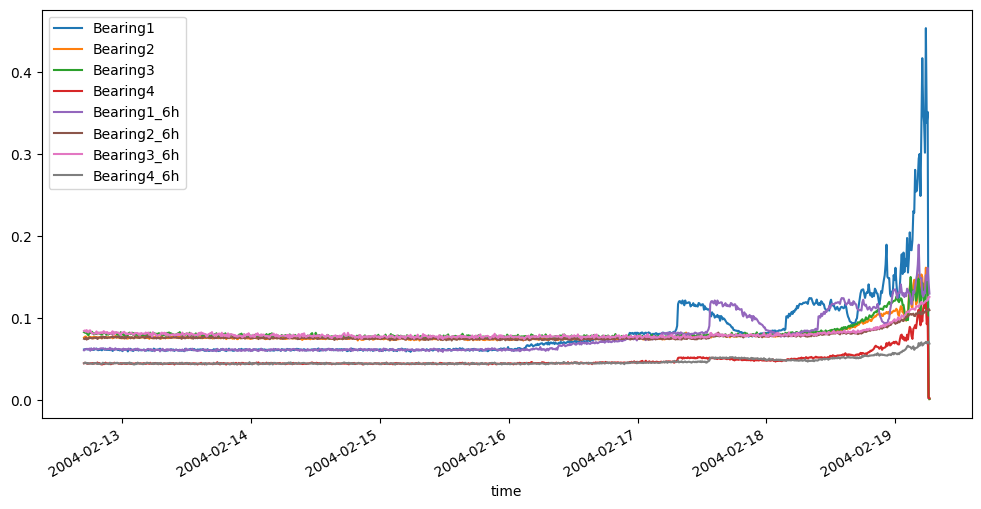

In [70]:
df_6.plot(figsize=(12, 6))

<Axes: xlabel='time'>

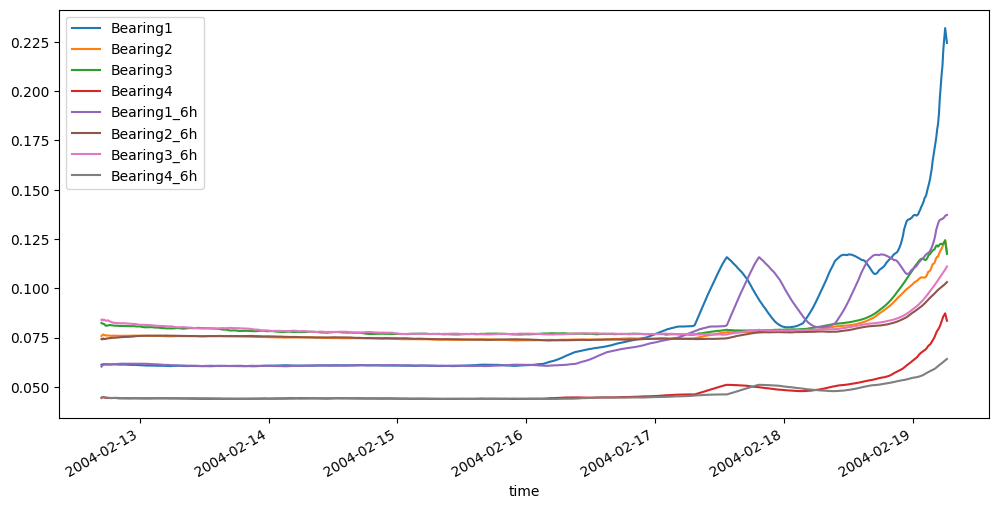

In [71]:
df_6_window.plot(figsize=(12, 6))

## 이상 탐지 모델링

### · Model Selection
---
* PCA Anomaly Detection
```
# 여러 변수 간에 존재하는 상관관계를 이용하여 이를 대표한 주성분을 추출해 차원을 축소하는 기법
# 기존 데이터의 유실을 최소하 하기 위해 데이터의 분산을 최대화 할 수 있는 초평면(Hyper plane)을 찾고 데이터를 투영함
# Auto encoder와 작동원리가 비슷함
# 다중공선성을 제거하기 위해 각 벡터의 축이 직각이 되도록 투영 시킴
# 원본 데이터의 Feature 개수에 비해 매우 적은 주성분으로 원본 데이터의 총 변동성을 대부분 설명할 수 있는 분석법
```
<img src = "https://drive.google.com/uc?id=16dNJTSMUiFmk4wQtJ7hP3HmL0wUy1vgP">

* 장단점
```
  # [good] 고차원에 데이터를 저차원에 주성분으로 표현할 수 있음
  # [good] 선택한 변수들의 해석이 용이함
  # [bad] 변수간 상관관계 고려가 어려움 
  # [bad] 추출된 변수의 해석이 어려움 (※ 주성분, PC1/PC2 ...)
```

### · 차원축소 및 변수 설명력 확인
---

In [116]:
df_6

,Bearing1,Bearing2,Bearing3,Bearing4,Bearing1_6h,Bearing2_6h,Bearing3_6h,Bearing4_6h
time,,,,,,,,
2004-02-12 16:52:39,0.061219,0.075748,0.082365,0.044376,0.060236,0.074227,0.083926,0.044443
2004-02-12 17:02:39,0.061413,0.076759,0.081682,0.045033,0.061455,0.073844,0.084457,0.045081
2004-02-12 17:12:39,0.061580,0.077017,0.081992,0.044675,0.061361,0.075609,0.082837,0.045118
2004-02-12 17:22:39,0.061917,0.075828,0.081084,0.044192,0.061665,0.073279,0.084879,0.044172
2004-02-12 17:32:39,0.061149,0.075487,0.079664,0.043657,0.061944,0.074593,0.082626,0.044659
...,...,...,...,...,...,...,...,...
2004-02-19 05:42:39,0.453335,0.161016,0.137440,0.119047,0.151880,0.108575,0.120528,0.070505
2004-02-19 05:52:39,0.337583,0.132400,0.144992,0.092125,0.145859,0.108005,0.120645,0.068641
2004-02-19 06:02:39,0.351111,0.152266,0.151299,0.100817,0.160895,0.108649,0.121147,0.070631


In [72]:
from sklearn.decomposition import PCA

x_train = df_6.loc[:'2004-02-14']
x_test = df_6['2004-02-15':]

pca = PCA(n_components=2, random_state=0)
x_train_pca = pd.DataFrame(pca.fit_transform(x_train))
x_train_pca.index = x_train.index

x_test_pca = pd.DataFrame(pca.transform(x_test))
x_test_pca.index = x_test.index

In [73]:
# ▶ pca.n_components_(차원 축소 주성분 개수)
print(pca.n_components_)

# ▶ pca.explained_variance_ratio_(설명력)
print(pca.explained_variance_ratio_)

# ▶ PC0, PC1으로도 전체 분산에 75% 이상 설명 가능

2
[0.5865346  0.17138469]


### · 시각화 및 Threshold 선정
---





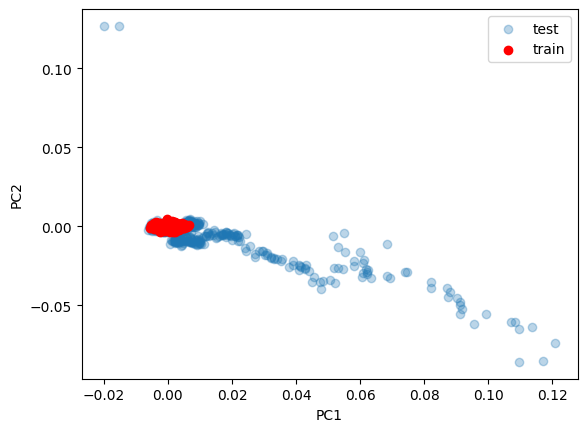

In [74]:

# 정규화


# 2개의 주성분으로 차원 축소
plt.figure()
plt.scatter(x_test_pca[0], x_test_pca[1], alpha=0.3, label='test')
plt.scatter(x_train_pca[0], x_train_pca[1], color='red', label='train')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend()
plt.show()

# 각 클러스터 중심에서 멀리 떨어진 Data 일 수록 이상치

In [75]:
df_pca = pd.concat([x_train_pca, x_test_pca])
restored_data = pca.inverse_transform(df_pca)

<Axes: xlabel='time'>

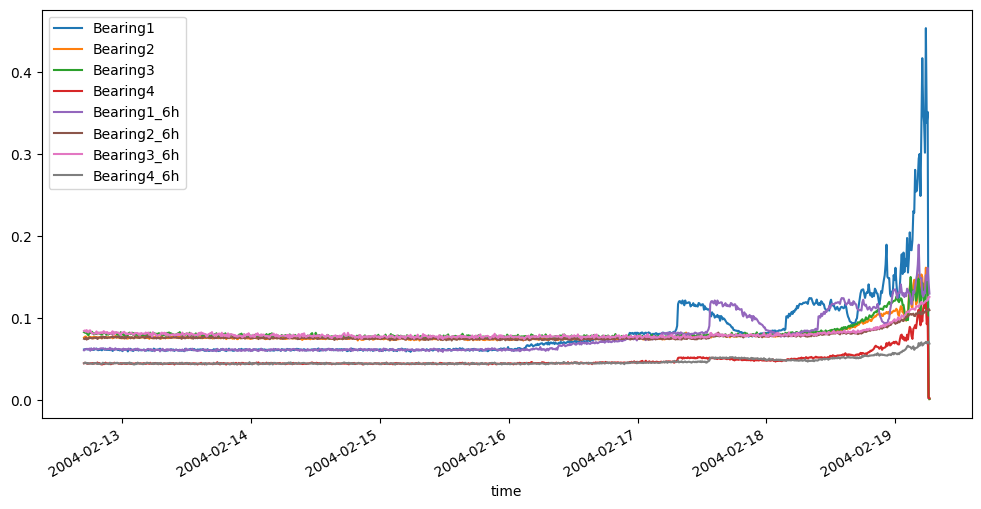

In [83]:
df_6.plot(figsize=(12, 6))

<Axes: >

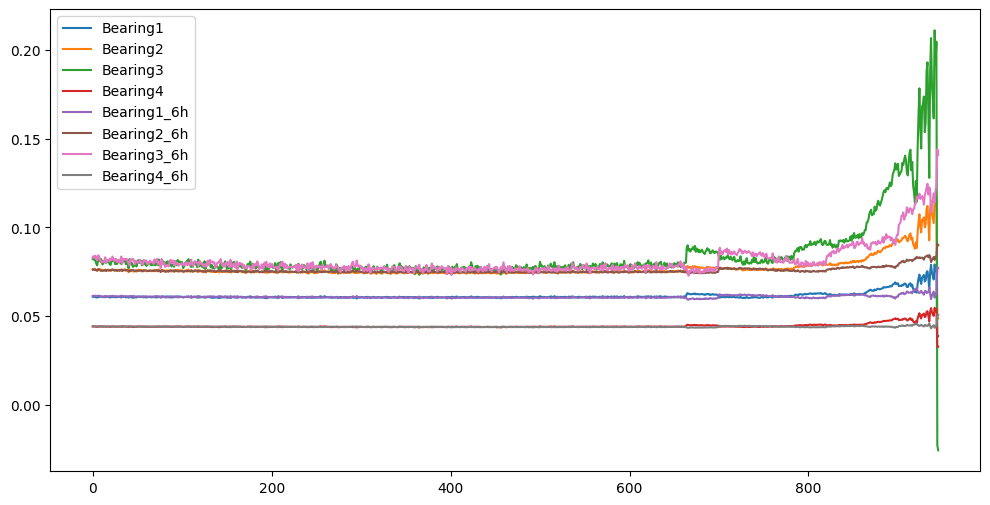

In [82]:
pd.DataFrame(restored_data, columns=df_6.columns).plot(figsize=(12, 6))

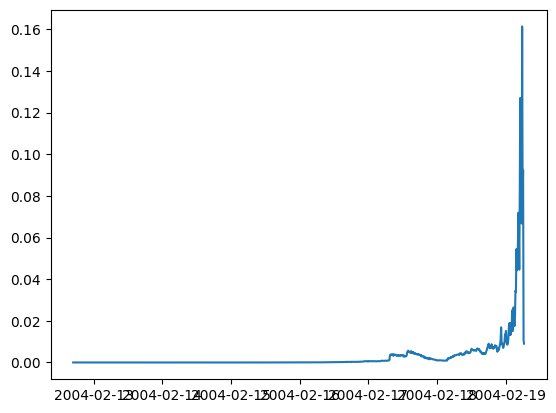

In [84]:
# PCA로 압축된 정보를 복원하여 복원오차로 등급을 부여

loss = np.sum((df_6 - restored_data) ** 2, axis=1)
plt.plot(loss)

In [91]:
threshold = 0.002
predict = loss > threshold
predict

time
2004-02-12 16:52:39    False
2004-02-12 17:02:39    False
2004-02-12 17:12:39    False
2004-02-12 17:22:39    False
2004-02-12 17:32:39    False
                       ...  
2004-02-19 05:42:39     True
2004-02-19 05:52:39     True
2004-02-19 06:02:39     True
2004-02-19 06:12:39     True
2004-02-19 06:22:39     True
Length: 946, dtype: bool

### · Abnormal Labeling
---





<Axes: xlabel='time'>

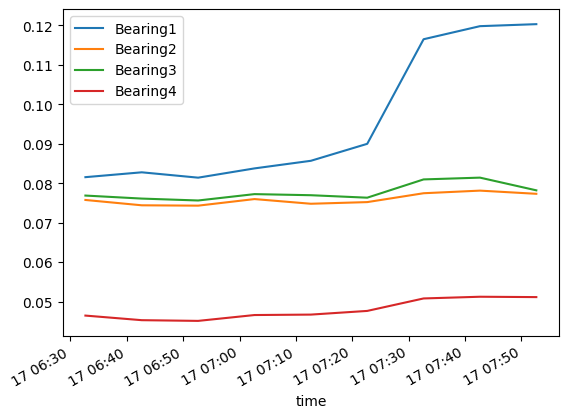

In [98]:
df.loc['2004-02-17 06:30:00':'2004-02-17 08:00:00'].plot()
# 2월 17일 07시 30분부터 이상으로 간주

In [105]:
# np.where 활용 if문 
label = np.where(df_6['Bearing1'] > 0.1, 1, 0)
label

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [109]:
# 기존 Data의 index를 부여
label = pd.DataFrame(label, index=df_6.index, columns=['label'])
label

,label
time,
2004-02-12 16:52:39,0
2004-02-12 17:02:39,0
2004-02-12 17:12:39,0
2004-02-12 17:22:39,0
2004-02-12 17:32:39,0
...,...
2004-02-19 05:42:39,1
2004-02-19 05:52:39,1
2004-02-19 06:02:39,1


In [111]:
# 기존 data와 Concat
data = pd.concat([df_6, label], axis=1)
data

,Bearing1,Bearing2,Bearing3,Bearing4,Bearing1_6h,Bearing2_6h,Bearing3_6h,Bearing4_6h,label
time,,,,,,,,,
2004-02-12 16:52:39,0.061219,0.075748,0.082365,0.044376,0.060236,0.074227,0.083926,0.044443,0
2004-02-12 17:02:39,0.061413,0.076759,0.081682,0.045033,0.061455,0.073844,0.084457,0.045081,0
2004-02-12 17:12:39,0.061580,0.077017,0.081992,0.044675,0.061361,0.075609,0.082837,0.045118,0
2004-02-12 17:22:39,0.061917,0.075828,0.081084,0.044192,0.061665,0.073279,0.084879,0.044172,0
2004-02-12 17:32:39,0.061149,0.075487,0.079664,0.043657,0.061944,0.074593,0.082626,0.044659,0
...,...,...,...,...,...,...,...,...,...
2004-02-19 05:42:39,0.453335,0.161016,0.137440,0.119047,0.151880,0.108575,0.120528,0.070505,1
2004-02-19 05:52:39,0.337583,0.132400,0.144992,0.092125,0.145859,0.108005,0.120645,0.068641,1
2004-02-19 06:02:39,0.351111,0.152266,0.151299,0.100817,0.160895,0.108649,0.121147,0.070631,1


### · 모델 평가
---





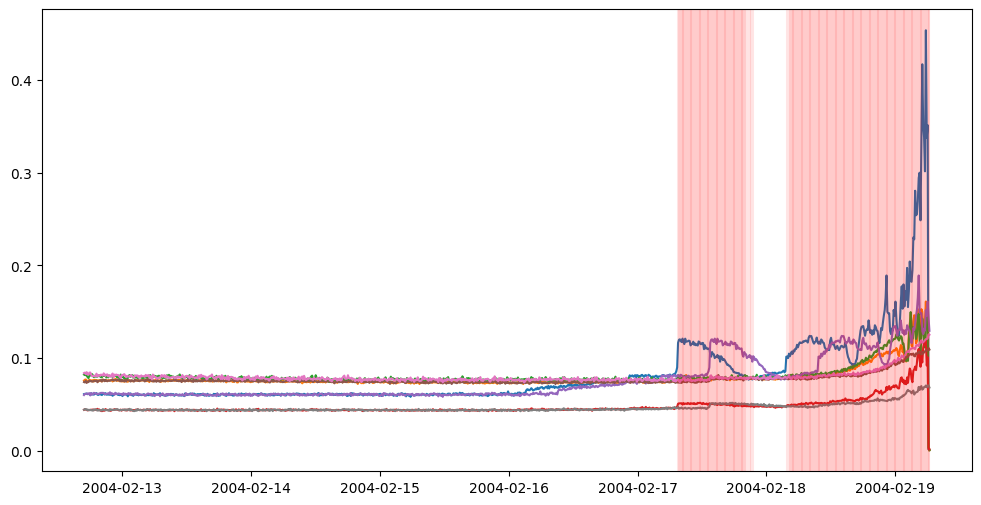

In [112]:
# Anomaly Points Plot
plt.figure(figsize = (12, 6))
plt.plot(df_6)
for idx in predict.index:
    if predict.loc[idx]:
        plt.axvline(idx, color='r', alpha=0.1)
plt.show()

In [113]:
predict

time
2004-02-12 16:52:39    False
2004-02-12 17:02:39    False
2004-02-12 17:12:39    False
2004-02-12 17:22:39    False
2004-02-12 17:32:39    False
                       ...  
2004-02-19 05:42:39     True
2004-02-19 05:52:39     True
2004-02-19 06:02:39     True
2004-02-19 06:12:39     True
2004-02-19 06:22:39     True
Length: 946, dtype: bool

In [114]:
label

,label
time,
2004-02-12 16:52:39,0
2004-02-12 17:02:39,0
2004-02-12 17:12:39,0
2004-02-12 17:22:39,0
2004-02-12 17:32:39,0
...,...
2004-02-19 05:42:39,1
2004-02-19 05:52:39,1
2004-02-19 06:02:39,1
